# Name

Yuting Kou, Yizhou Wang, Yiming Xu, Ziyi Zhou

## Content

## Method

## Toy Example

In [1]:
import matplotlib.pyplot as plt
from autograd import numpy as np
import time
from Inference import Inference
from Subspace import Subspace
from model import Model
from util import hidecode
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

In [2]:
# data = np.load(r'.\example\data.npy')
data = np.genfromtxt(r'../example/hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture, Sigma_Y=0.25)

# use MSE result as params_init
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 65.1166805377315; gradient mag: 164.7321094609157
Iteration 100 lower bound 52.86436046756695; gradient mag: 56.954586390884565
Iteration 200 lower bound 49.42633385370295; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.73326189562314; gradient mag: 18.311751879565836
Iteration 400 lower bound 46.647745693540806; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.88691542805831; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.192575322800902
Iteration 800 lower bound 26.97792508592485; gradient mag: 20.35417699419094
Iteration 900 lower bound 24.278363637665734; gradient mag: 18.779125916898224
Iteration 1000 lower bound 22.02986716940495; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.21045518866592
Iteration 1200 lower bound 18.434367471681025; gradient mag: 15.0920445

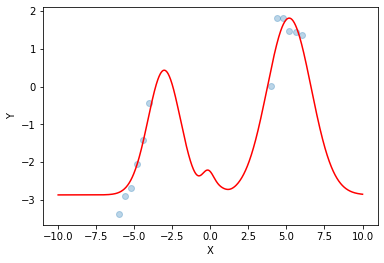

In [3]:
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y');

## Random

In [4]:
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [6]:
hmc_tune_params={'step_size':1e-3,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [7]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.001
HMC 400: accept rate of 100.0 with step size 0.0024986540807898465
HMC 600: accept rate of 100.0 with step size 0.003998654080789847
HMC 800: accept rate of 99.5 with step size 0.005496107018331699
HMC 1000: accept rate of 99.2 with step size 0.0069961070183316995
HMC 1200: accept rate of 99.25 with step size 0.0084961070183317
HMC 1400: accept rate of 99.14285714285714 with step size 0.0099961070183317
HMC 1600: accept rate of 98.4375 with step size 0.0114961070183317
HMC 1800: accept rate of 98.44444444444444 with step size 0.012996107018331699
HMC 2000: accept rate of 97.55 with step size 0.014483679319678514
HMC 2200: accept rate of 97.54545454545455 with step size 0.013584283047289737
HMC 2400: accept rate of 96.91666666666666 with step size 0.015077158763740418
HMC 2600: accept rate of 96.8076923076923 with step size 0.01657715876374042
HMC 2800: accept rate of 96.46428571428571 with step size 0.017669040504051915
HMC 3000: accep

In [8]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 10.03 min


In [9]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

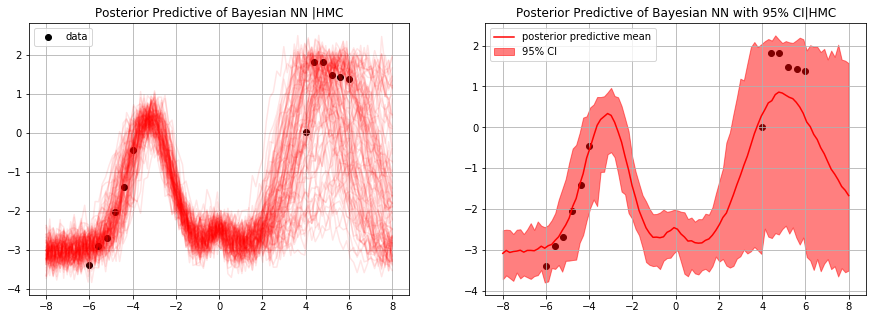

In [10]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

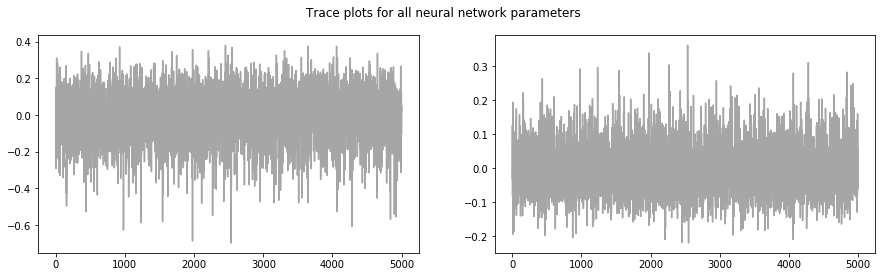

In [11]:
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

## PCA

In [4]:
my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [5]:
hmc_tune_params={'step_size':5e-2,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

In [7]:
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=5)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)


In [8]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.05
HMC 400: accept rate of 100.0 with step size 0.05149590628513469
HMC 600: accept rate of 100.0 with step size 0.05299590628513469
HMC 800: accept rate of 100.0 with step size 0.05449448304423065
HMC 1000: accept rate of 99.9 with step size 0.05599448304423065
HMC 1200: accept rate of 99.91666666666667 with step size 0.057493318828562366
HMC 1400: accept rate of 99.92857142857143 with step size 0.05899331882856237
HMC 1600: accept rate of 99.9375 with step size 0.060491307848387584
HMC 1800: accept rate of 99.94444444444444 with step size 0.061991307848387585
HMC 2000: accept rate of 99.95 with step size 0.06348952546446875
HMC 2200: accept rate of 99.95454545454545 with step size 0.06498566052361361
HMC 2400: accept rate of 99.95833333333334 with step size 0.06648323861727212
HMC 2600: accept rate of 99.96153846153845 with step size 0.067973645140047
HMC 2800: accept rate of 99.96428571428572 with step size 0.06947264431418144
HMC 3000:

In [9]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 7.68 min


In [10]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

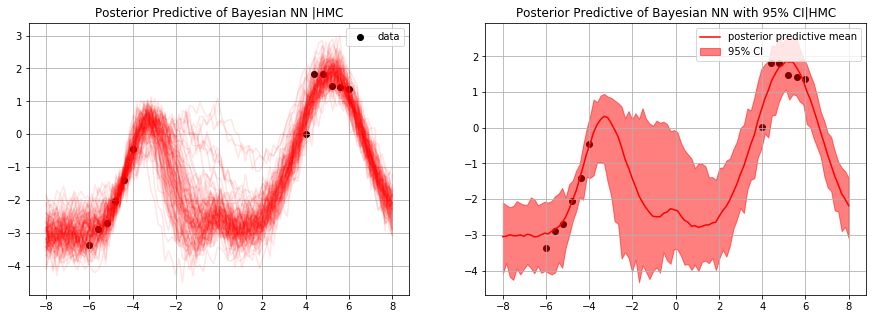

In [11]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

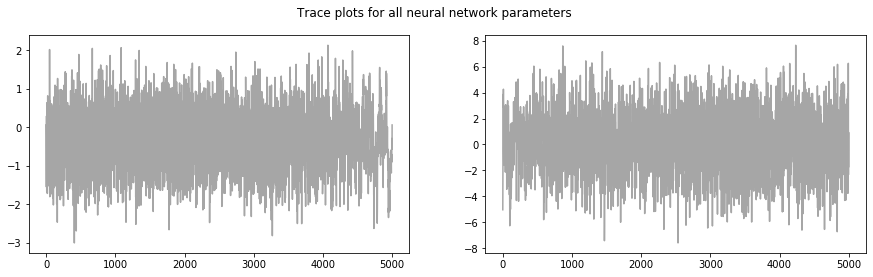

In [12]:
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

## PCA (extension)

In paper, the deviation matrix is updated during equal epoch intervals. However, to construct a more precise subspace, it is also very possible that the projection matrix $P$ is the PCA component of the smallest deviation instead of the equal-interval deviation. 

`[补充basic idea!!]`

To formulate the expression, we have the following definition:
<br>$w0$: pretrained weights;
<br>$\eta$: learning rate;
<br>$T$: number of steps;
<br>$c$: moment update frequency;
<br>$M$: maximum number of columns in deviation matrix;
<br>$K$: rank of PCA approximation;
<br>$A$: deviation matrix;
<br>$P$: projection matrix for subspace


The original algorithm to construct subspace with PCA goes as follows:

<p style="text-align: right">step0 [Initialize mean] </p>
<br>$w_{SWA} \leftarrow w_0$
<p style="text-align: right">step1 [SGD Update]</p>
<br>for $i\leftarrow1,2,\cdots, T \text{ do}$
<br>$\quad$ $w_i \leftarrow w_{i-1} - \eta \nabla_{w}\mathcal{L}(w_{i-1})$
<p style="text-align: right">step2 [SWA Update]</p>
<br>$\quad$ if MOD$(i,c)=0$ then
<br>$\quad\quad$ $n\leftarrow i/c$
<br>$\quad\quad$ $w_{SWA}\leftarrow \frac{nw_{SWA} + w_i}{n+1}$
<p style="text-align: right">step3 [devation matrix Update]</p>
<br>$\quad\quad$ if NUM_COLS($A$) = $M$ then
<br>$\quad\quad\quad$ REMOVE_COL($A$[:,1])
<br>$\quad\quad$ APPEND_COLS($A$, $w_i - \bar{w}$)
<p style="text-align: right">step4 [Truncated SVD]</p>
<br>$U,S,V^{T}\leftarrow SVD(A)$
<br>return $\hat{w} = w_{SWA}$, $P = SV^T$

In our algorithm, we mainly change step3 (deviation matrix update process) to store the smallest $M$ deviation among all deviations. One difficulty of this algorithm is how to find the minimum $M$ deviations with an efficient use of memory. That is to say, if we stored all possible devations in a pretty :
<br>$\quad\quad$ if NUM_COLS($A$) = $M$ then
<br>$\quad\quad\quad$ REMOVE_COL($A$[:,1])
<br>$\quad\quad$ APPEND_COLS($A$, $w_i - \bar{w}$)